In [1]:
#All Necessary Imports
import numpy as np
import os
import time
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

PATH = "/home/yahya/Desktop/Ammars/Diabetic-Retinopathy-Detection-WebApp/data/diabetic-retinopathy-detection/"


In [2]:
#loading base model
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
#freeze_layers(base_model)
base_model.summary()
#model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)


2022-03-17 12:09:35.423754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 12:09:35.448435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-17 12:09:35.448463: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-17 12:09:35.449566: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-3]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)
base_model.summary()

<keras.engine.input_layer.InputLayer object at 0x7f4787b9ec40> False
<keras.layers.convolutional.Conv2D object at 0x7f47569a93a0> False
<keras.layers.convolutional.Conv2D object at 0x7f47569a99a0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f475613aeb0> False
<keras.layers.convolutional.Conv2D object at 0x7f475613a070> False
<keras.layers.convolutional.Conv2D object at 0x7f47547c1310> False
<keras.layers.pooling.MaxPooling2D object at 0x7f47547c74f0> False
<keras.layers.convolutional.Conv2D object at 0x7f4756d46340> False
<keras.layers.convolutional.Conv2D object at 0x7f47547bbbe0> False
<keras.layers.convolutional.Conv2D object at 0x7f47547cd880> False
<keras.layers.pooling.MaxPooling2D object at 0x7f47547d4460> False
<keras.layers.convolutional.Conv2D object at 0x7f47547c7850> False
<keras.layers.convolutional.Conv2D object at 0x7f47547d8fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f47547d4cd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4754762d60>

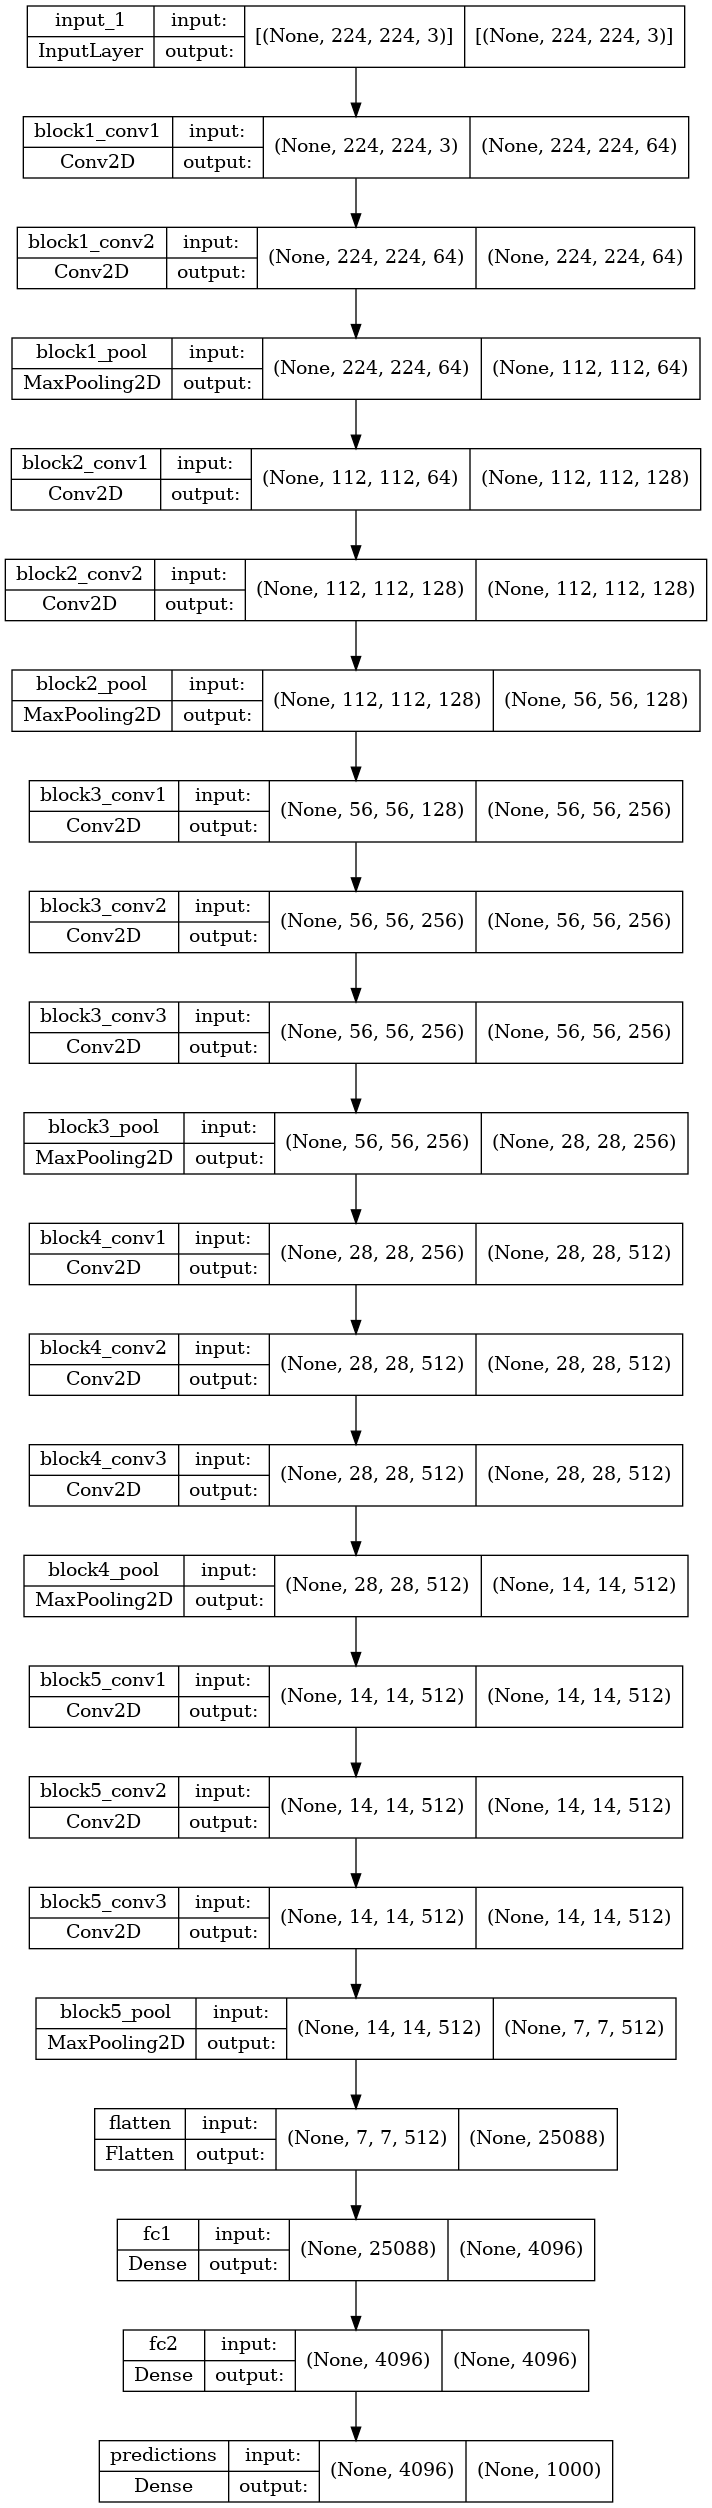

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(base_model, to_file='base_model_plot.png', show_shapes=True, show_layer_names=True)

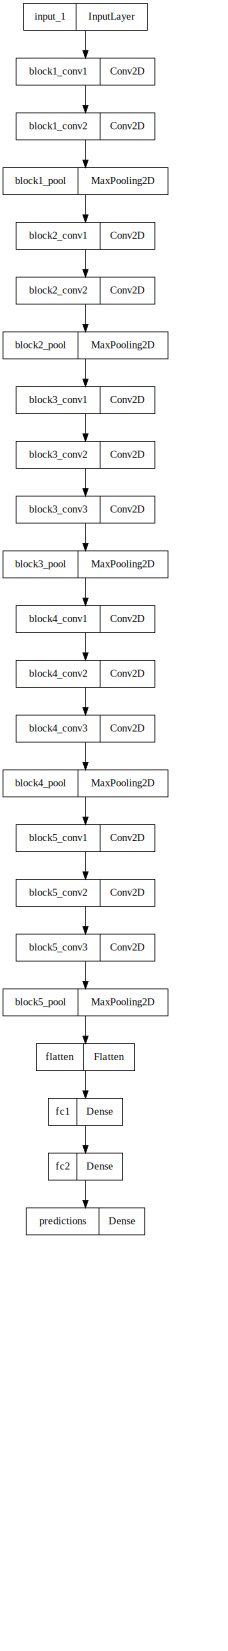

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_model).create(prog='dot', format='svg'))

In [6]:
#batch_size to train
batch_size = 1
# number of output classes
nb_classes = 5
# number of epochs to train
nb_epoch = 3

In [7]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(base_model)
 
# Add new layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(nb_classes, activation='softmax', name ='output'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 1024)              1025024   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 output (Dense)              (None, 5)                 5125      
                                                                 
Total params: 139,387,693
Trainable params: 124,673,005
Non-trainable params: 14,714,688
_________________________________________________________________


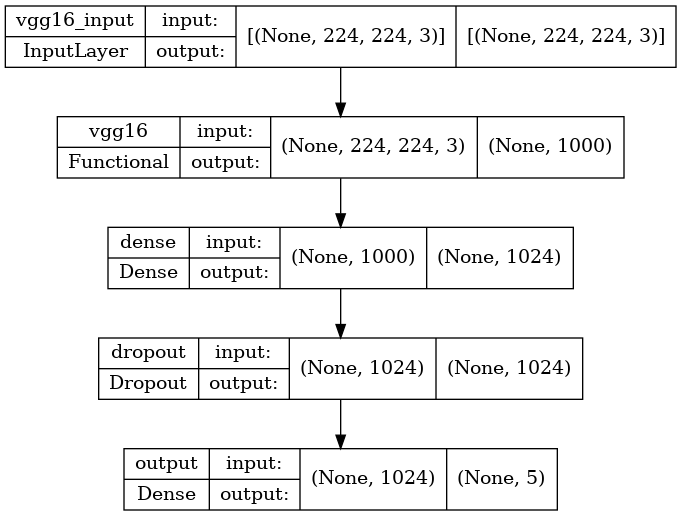

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='finetune_model_plot.png', show_shapes=True, show_layer_names=True)

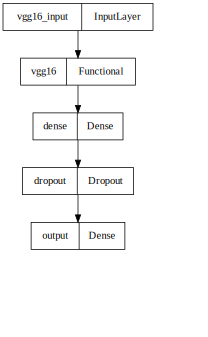

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Loading the dataset

In [10]:
import pandas as pd
trainLabels = pd.read_csv(PATH + "trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


/home/yahya/anaconda3/envs/Ammar/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='level', ylabel='count'>

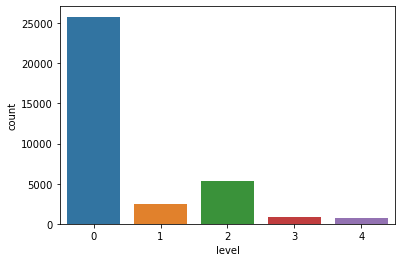

In [11]:
import seaborn as sns
sns.countplot("level",data= trainLabels)

In [12]:
import os
dirpath = PATH + "train/"
listing = os.listdir(dirpath) 
# listing.remove("trainLabels.csv")
np.size(listing)
# print(listing)

35126

In [13]:


from PIL import Image

# input image dimensions
img_rows, img_cols = 224, 224

immatrix = []
imlabel = []
for file in listing:
    base = os.path.join(os.path.sep, dirpath, file)
    fileName = file.replace('.jpeg','')
    # print(fileName)
    imlabel.append(trainLabels.loc[trainLabels.image==fileName, 'level'].values[0])
    im = Image.open(dirpath + file)   
    img = im.resize((img_rows,img_cols))
    rgb = img.convert('RGB')
    immatrix.append(np.array(rgb).flatten())

In [14]:

from sklearn.utils import shuffle

#converting images & labels to numpy arrays
immatrix = np.asarray(immatrix)
imlabel = np.asarray(imlabel)


data,Label = shuffle(immatrix,imlabel, random_state=2)
train_data = [data,Label]
type(train_data)

list

severity 1
severity 1
severity 0
severity 0
severity 0
severity 0
severity 0
severity 2
severity 2
severity 0


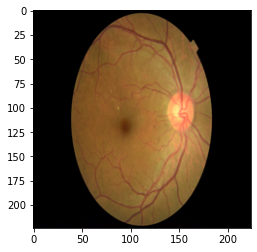

In [15]:
import matplotlib.pyplot as plt
import matplotlib
for i in range (10):
    img=immatrix[i].reshape(img_rows,img_cols,3)
    print('severity',imlabel[i])
    if(imlabel[i]>0):
        plt.imshow(img)
    

In [16]:
(X, y) = (train_data[0],train_data[1])
from sklearn.model_selection import train_test_split

# STEP 1: split X and y into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 3)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 3)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28100, 224, 224, 3)
(28100,)
(7026, 224, 224, 3)
(7026,)


In [ ]:
# X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 3)
# X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

In [ ]:
from keras.utils import np_utils

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# create generators  - training data will be augmented images
validationdatagenerator = ImageDataGenerator()
traindatagenerator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1 )

batchsize=8
train_generator=traindatagenerator.flow(X_train, Y_train, batch_size=batchsize) 
validation_generator=validationdatagenerator.flow(X_test, Y_test,batch_size=batchsize)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
import tensorflow as tf
#Saving checkpoints while training
checkpoint_path = "/home/yahya/Desktop/Ammars/checkpoints/cp-.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
import datetime
#creating tensorboard callback
log_dir = "/home/yahya/Desktop/Ammars/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history= model.fit_generator(train_generator, steps_per_epoch=int(len(X_train)/batchsize), 
                            epochs=10, validation_data=validation_generator, 
                            validation_steps=int(len(X_test)/batchsize),
                            callbacks=[cp_callback])
model.save("/home/yahya/Desktop/Ammars/modelSaves")

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest
os.listdir(checkpoint_dir)
print(checkpoint_dir)
print(checkpoint_path)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

In [ ]:
from keras.models import load_model
model.save('/home/yahya/Desktop/Ammars/modelSaves/retinopathy_predict.h5')

In [ ]:
print(X_train.shape)
print(X_test[0].shape)
y_pred = []
p = 100
for i in range (200):
    image = X_train[i]
    imagematrix =  np.asarray(image)
    img1=imagematrix.reshape(img_rows,img_cols,3)
    plt.imshow(img1)
    print(imagematrix.shape)
    imagepredict = np.expand_dims(imagematrix, axis=0)
    print(imagepredict.shape)
    y_pred1 = model.predict(imagepredict)
    y_pred2 = [x * p for x in y_pred1]
    y_pred3 = np.max(y_pred2)
    y_pred.append(y_pred3)
    print(y_pred3)
y_pred = np.asarray(y_pred)

In [ ]:
print(model.input_shape)
print(model.output_shape)

In [ ]:
new_model = tf.keras.models.load_model('/home/yahya/Desktop/Ammars/modelSaves/retinopathy_predict.h5')
new_model.summary()